In [1]:
from src.model import VAE
from src.trainer import CDVAETrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
len(mnist)

60000

In [6]:
from src.utils import CMNISTGenerator, CMNIST

In [7]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [8]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.2,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
        corruptions.brightness: 0.2
    },
)


In [9]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:14<00:00, 4270.73item/s]


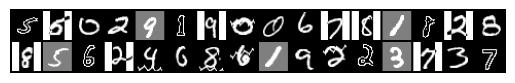

In [10]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


### cosine sim + label-flipping

In [11]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [100, 100]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/4, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [12]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 99.62it/s] 


val_recontr_loss=60.779, val_kl_c=8.791, val_kl_s=10.126, val_c_loss=0.203, val_s_loss=0.110
gMIG: 0.182; elbo: 79.697


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 256.52it/s]


val_recontr_loss=31.902, val_kl_c=9.822, val_kl_s=13.868, val_c_loss=0.095, val_s_loss=0.113
gMIG: 0.254; elbo: 55.592


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 254.83it/s]


val_recontr_loss=25.960, val_kl_c=10.530, val_kl_s=15.065, val_c_loss=0.086, val_s_loss=0.113
gMIG: 0.267; elbo: 51.555


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 202.53it/s]


val_recontr_loss=23.521, val_kl_c=11.151, val_kl_s=15.792, val_c_loss=0.077, val_s_loss=0.112
gMIG: 0.275; elbo: 50.465


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 240.15it/s]


val_recontr_loss=22.068, val_kl_c=11.417, val_kl_s=16.666, val_c_loss=0.086, val_s_loss=0.112
gMIG: 0.269; elbo: 50.151


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 250.79it/s]


val_recontr_loss=19.892, val_kl_c=12.001, val_kl_s=16.698, val_c_loss=0.071, val_s_loss=0.111
gMIG: 0.28; elbo: 48.592


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 245.93it/s]


val_recontr_loss=19.144, val_kl_c=12.129, val_kl_s=16.688, val_c_loss=0.070, val_s_loss=0.112
gMIG: 0.275; elbo: 47.961


In [13]:
trainer.evaluate(test_loader, False, 0)

(0.28282013769544423, -47.96543655151757)

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [124]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [127]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [131]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [132]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [ ]:
display_util(9, 2, z, vae, int(Z_DIM / 2))

### cosine sim + no lable-flipping

In [166]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [100, 100]
LABEL_FLIPPING = False

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [ ]:
trainer.fit(31, dataloader, val_dataloader)

In [168]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [169]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [ ]:
display_util(9, 26, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [35]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 9
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### mahalanobis + label flipping

In [111]:
Z_DIM = 32
TEMP = 1
ALPHA = [50, 50]
LABEL_FLIPPING = True

In [94]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="mahalanobis",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [ ]:
trainer.fit(31, dataloader, val_dataloader)

In [96]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

In [ ]:
display_util(9, 16, z, vae, 16)

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

In [103]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [106]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))